In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import scipy as sc
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import glob

In [3]:
##data must be converted into a 2D matrix for pca analysis
##transform takes a 3D data array (time, a, b) -> (a*b, time)
##(the data grid is flattened a column using numpy.flatten)

def transform(xarr):
    arr = np.array(xarr) ##converting to numpy array
    arr = arr.reshape(arr.shape[0], arr.shape[1]*arr.shape[2]) ##reshaping from size (a, b, c) to (a, b*c)
    arr = arr.transpose()
    return arr

def reverse(mat, orig_shape):
    arr = np.copy(mat)
    arr = arr.transpose()
    arr = arr.reshape(-1, orig_shape[1], orig_shape[2]) ##reshaping back to original array shape
    return arr

In [3]:
## 3-hour averaged matrix

u_data = np.empty( (8*len(files), 266, 256)) 
v_data = np.empty( (8*len(files), 266, 256)) 

for i in range(len(files)):
    dayX = xr.open_dataset(files[i])
    for j in range(8):
        u_3 = np.array( dayX['u_wind'][j*3:j*3 + 3, 0:266, 0:256] )
        v_3 = np.array( dayX['v_wind'][j*3:j*3 + 3, 0:266, 0:256] )
        avg_u = u_3.mean(axis = 0) ##average of 3-hour time interval
        avg_v = v_3.mean(axis = 0)
        u_data[8*i + j, : , : ] = avg_u[0:266, 0:256] ##adding 3-hour average to new data array
        v_data[8*i + j, : , : ] = avg_v[0:266, 0:256]
        
del u_3
del v_3
del avg_u
del avg_v
del dayX

In [6]:
hr_eigs = np.array(pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/eigvecs_hrdps_annual.csv', header = None))
hr_PCs = np.array(pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/PCs_hrdps_annual.csv', header = None))
print(hr_PCs.shape)
print(hr_eigs.shape)

(136192, 50)
(50, 2904)


In [7]:
new_eigs = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/eigvecs_recon.csv', header = None) )
print(new_eigs.shape)

## Analysing Reconstructed Data

In [10]:
recon = np.matmul(hr_PCs[:,0:20], new_eigs) + np.mean(hr_data)
split4 = int( recon.shape[0]/2 )
u_data_rec = reverse(recon[:split4,:], (0, 266, 256)) ##reconstructing u_winds from n PCs
v_data_rec = reverse(recon[split4:,:], (0, 266, 256)) ##reconstructing v_winds from n PCs

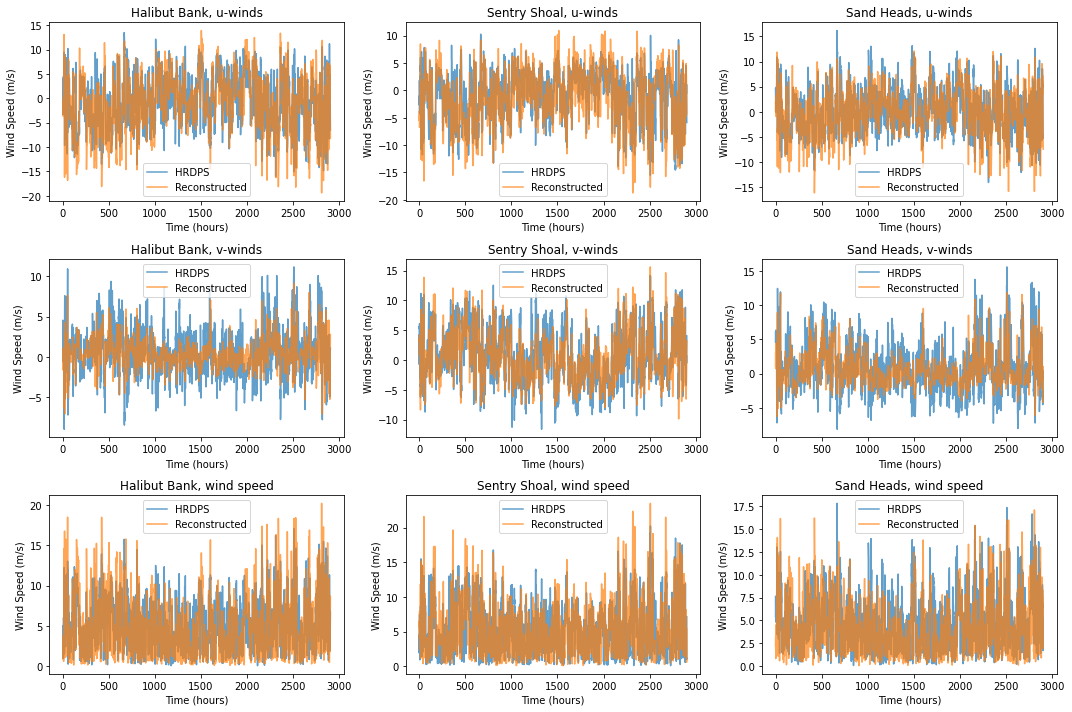

In [11]:
## Plotting data at three locations.

fig, ax = plt.subplots(3, 3, figsize=(15, 10))
alpha_val = 0.7

ax[0, 0].plot(u_data[:,142,139], label = "HRDPS", alpha = alpha_val)
ax[0, 0].plot(u_data_rec[:,142,139], label = "Reconstructed", alpha = alpha_val)
ax[0, 0].set_title("Halibut Bank, u-winds")
ax[0, 0].set_xlabel("Time (hours)")
ax[0, 0].set_ylabel("Wind Speed (m/s)")
ax[0, 0].legend()

ax[0, 1].plot(u_data[:,174,107], label = "HRDPS", alpha = alpha_val)
ax[0, 1].plot(u_data_rec[:,174,107], label = "Reconstructed", alpha = alpha_val)
ax[0, 1].set_title("Sentry Shoal, u-winds")
ax[0, 1].set_xlabel("Time (hours)")
ax[0, 1].set_ylabel("Wind Speed (m/s)")
ax[0, 1].legend()

ax[0, 2].plot(u_data[:,129,149], label = "HRDPS", alpha = alpha_val)
ax[0, 2].plot(u_data_rec[:,129, 149], label = "Reconstructed", alpha = alpha_val)
ax[0, 2].set_title("Sand Heads, u-winds")
ax[0, 2].set_xlabel("Time (hours)")
ax[0, 2].set_ylabel("Wind Speed (m/s)")
ax[0, 2].legend()

ax[1, 0].plot(v_data[:,142,139], label = "HRDPS", alpha = alpha_val)
ax[1, 0].plot(v_data_rec[:,142,139], label = "Reconstructed", alpha = alpha_val)
ax[1, 0].set_title("Halibut Bank, v-winds")
ax[1, 0].set_xlabel("Time (hours)")
ax[1, 0].set_ylabel("Wind Speed (m/s)")
ax[1, 0].legend()

ax[1, 1].plot(v_data[:,174,107], label = "HRDPS", alpha = alpha_val)
ax[1, 1].plot(v_data_rec[:,174,107], label = "Reconstructed", alpha = alpha_val)
ax[1, 1].set_title("Sentry Shoal, v-winds")
ax[1, 1].set_xlabel("Time (hours)")
ax[1, 1].set_ylabel("Wind Speed (m/s)")
ax[1, 1].legend()

ax[1, 2].plot(v_data[:,129,149], label = "HRDPS", alpha = alpha_val)
ax[1, 2].plot(v_data_rec[:,129, 149], label = "Reconstructed", alpha = alpha_val)
ax[1, 2].set_title("Sand Heads, v-winds")
ax[1, 2].set_xlabel("Time (hours)")
ax[1, 2].set_ylabel("Wind Speed (m/s)")
ax[1, 2].legend()

ax[2,0].plot(np.sqrt(u_data[:,142,139]**2 + v_data[:,142,139]**2), label = "HRDPS", alpha = alpha_val)
ax[2,0].plot(np.sqrt(u_data_rec[:,142,139]**2 + v_data_rec[:,142,139]**2), label = "Reconstructed", alpha = alpha_val)
ax[2,0].set_xlabel("Time (hours)")
ax[2,0].set_title("Halibut Bank, wind speed")
ax[2,0].set_ylabel("Wind Speed (m/s)")
ax[2,0].legend()

ax[2,1].plot(np.sqrt(u_data[:,174,107]**2 + v_data[:,174,107]**2), label = "HRDPS", alpha = alpha_val)
ax[2,1].plot(np.sqrt(u_data_rec[:,174,107]**2 + v_data_rec[:,174,107]**2), label = "Reconstructed", alpha = alpha_val)
ax[2,1].set_xlabel("Time (hours)")
ax[2,1].set_title("Sentry Shoal, wind speed")
ax[2,1].set_ylabel("Wind Speed (m/s)")
ax[2,1].legend()

ax[2,2].plot(np.sqrt(u_data[:,129,149]**2 + v_data[:,129,149]**2) , label = "HRDPS", alpha = alpha_val)
ax[2,2].plot(np.sqrt(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2) , label = "Reconstructed", alpha = alpha_val)
ax[2,2].set_xlabel("Time (hours)")
ax[2,2].set_title("Sand Heads, wind speed")
ax[2,2].set_ylabel("Wind Speed (m/s)")
ax[2,2].legend()

plt.tight_layout()

In [12]:
nums = np.arange(0, 37, 3)
print(nums)

[ 0  3  6  9 12 15 18 21 24 27 30 33 36]


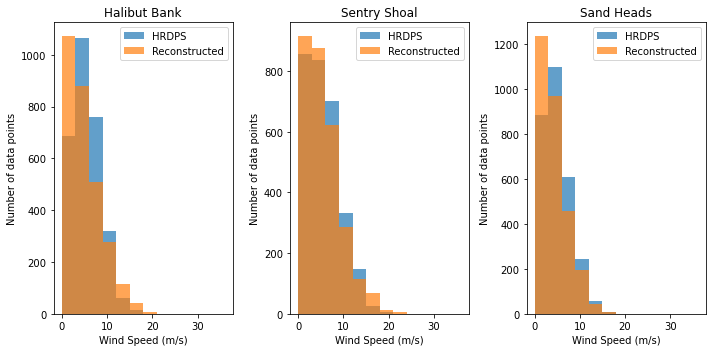

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].set_title("Halibut Bank")
ax[0].hist(np.sqrt(u_data[:,142,139]**2 + v_data[:,142,139]**2), bins = nums, label = "HRDPS", alpha = 0.7)
ax[0].hist(np.sqrt(u_data_rec[:,142,139]**2 + v_data_rec[:,142,139]**2), bins = nums, label = "Reconstructed", alpha = 0.7)
ax[0].set_xlabel("Wind Speed (m/s)")
ax[0].set_ylabel("Number of data points")
ax[0].legend()

ax[1].set_title("Sentry Shoal")
ax[1].hist(np.sqrt(u_data[:,174,107]**2 + v_data[:,174,107]**2), bins = nums, label = "HRDPS", alpha = 0.7)
ax[1].hist(np.sqrt(u_data_rec[:,174,107]**2 + v_data_rec[:,174,107]**2), bins = nums, label = "Reconstructed", alpha = 0.7)
ax[1].set_xlabel("Wind Speed (m/s)")
ax[1].set_ylabel("Number of data points")
ax[1].legend()

ax[2].set_title("Sand Heads")
ax[2].hist(np.sqrt(u_data[:,129,149]**2 + v_data[:,129,149]**2) , bins = nums,  label = "HRDPS", alpha = 0.7)
ax[2].hist(np.sqrt(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2) , bins = nums, label = "Reconstructed", alpha = 0.7)
ax[2].set_xlabel("Wind Speed (m/s)")
ax[2].set_ylabel("Number of data points")
ax[2].legend()

plt.tight_layout()

In [14]:
x = np.array([1, 2, 3])
y = np.array([2, 4, 6])
reg = LinearRegression().fit(x.reshape(-1, 1), y)
a = reg.coef_[0]
b = reg.intercept_
print(a, b)
print( reg.score(x.reshape(-1, 1), y) )

1.9999999999999996 8.881784197001252e-16
1.0


In [28]:
def helper(x, y, ax, i, j):
    
    if i == 2:
        myBool = False
    else:
        myBool = True
    
    reg = LinearRegression(fit_intercept = myBool).fit(x.reshape(-1, 1), y)
    a = reg.coef_[0]
    b = reg.intercept_
    y_pred = a*x + b
    
    bias = np.mean( y - x )
    r_squared = reg.score(x.reshape(-1, 1), y)
    rmse = np.sqrt( mean_squared_error(y, y_pred) )
    
    ax[i,j].scatter(x, y)
    ax[i,j].plot(x, a*x+b, color = 'orange')
    ax[i,j].annotate("r-squared = {:.3f}".format(r_squared), (-12, 17))
    ax[i,j].annotate("bias = {:.3f}".format(bias), (-12, 15))
    ax[i,j].annotate("RMS error = {:.3f}".format(rmse), (-12, 13))
    ax[i,j].annotate("y = {:.3f}x + {:.3f}".format(a, b), (-12, 11))
    ax[i,j].set_ylabel("HRDPS data")
    ax[i,j].set_xlabel("reconstructed data")
    ax[i,j].set_ylim(-13, 20)
    ax[i,j].set_xlim(-13, 20)
    return (a, b)

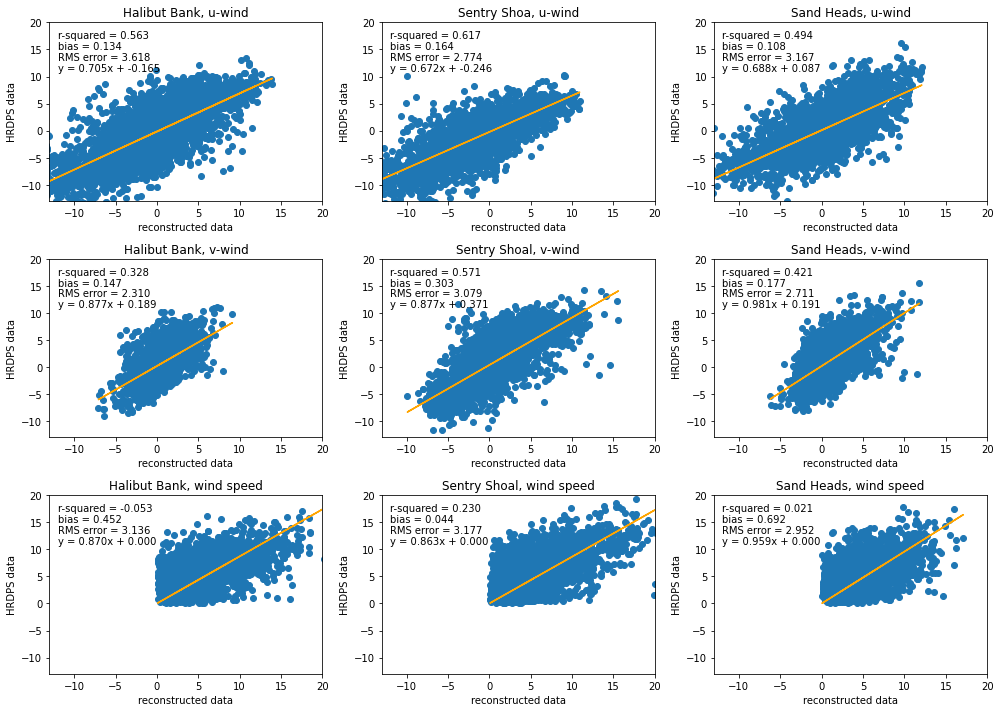

In [29]:
a = np.empty((3, 3))
b = np.empty((3, 3))

fig, ax = plt.subplots(3, 3, figsize = (14, 10))
##Habibut bank
y = u_data[:, 142, 139]
x = u_data_rec[:, 142, 139]
ax[0, 0].set_title("Halibut Bank, u-wind")
a[0,0], b[0,0] = helper(x, y, ax, 0, 0)

y = v_data[:, 142, 139]
x = v_data_rec[:, 142, 139]
ax[1, 0].set_title("Halibut Bank, v-wind")
a[1,0], b[1,0] = helper(x, y, ax, 1, 0)

y = np.sqrt(u_data[:, 142, 139]**2 + v_data[:, 142, 139]**2)
x = np.sqrt(u_data_rec[:, 142, 139]**2 + v_data_rec[:, 142, 139]**2)
ax[2, 0].set_title("Halibut Bank, wind speed")
a[2,0], b[2,0] = helper(x, y, ax, 2, 0)

##Sentry Shoal
y = u_data[:,174, 107]
x = u_data_rec[:,174, 107]
ax[0, 1].set_title("Sentry Shoa, u-wind")
a[0,1], b[0,1] = helper(x, y, ax, 0, 1)

y = v_data[:,174, 107]
x = v_data_rec[:,174, 107]
ax[1, 1].set_title("Sentry Shoal, v-wind")
a[1,1], b[1,1] = helper(x, y, ax, 1, 1)

y = np.sqrt(u_data[:,174, 107]**2 + v_data[:,174, 107]**2)
x = np.sqrt(u_data_rec[:,174, 107]**2 + v_data_rec[:,174, 107]**2)
ax[2, 1].set_title("Sentry Shoal, wind speed")
a[2,1], b[2,1] = helper(x, y, ax, 2, 1)

##Sand Heads
y = u_data[:,129,149]
x = u_data_rec[:,129,149]
ax[0, 2].set_title("Sand Heads, u-wind")
a[0,2], b[0,2] = helper(x, y, ax, 0, 2)

y = v_data[:,129,149]
x = v_data_rec[:,129,149]
ax[1, 2].set_title("Sand Heads, v-wind")
a[1,2], b[1,2] = helper(x, y, ax, 1, 2)

y = np.sqrt(u_data[:,129,149]**2 + v_data[:,129,149]**2)
x = np.sqrt(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2)
ax[2, 2].set_title("Sand Heads, wind speed")
a[2,2], b[2,2] = helper(x, y, ax, 2, 2)

plt.tight_layout()